# Categorização de avaliações

**Passos:**

1. **Pré-processamento**: Colocar em minúsculo, remover pontuação, stop words (conjunções, preposições, etc) e aplicar stemming ou lematização
    - Stemming: reduz palavras ao seu radical, ignorando as regras linguísticas (é útil para reduzir a dimensionalidade)
    - Lematização: Reduz palavras à sua forma básica, considerando o contexto gramatical (é mais precisa)
2. **Extração de Características**: Usar TF-IDF ou Word2Vec para criar representações vetoriais das avaliações
    - O TF-IDF (term frequence - inverse document frequency) calcula a relevância de cada termo dentro de um documento
    - O Word2Vec captura relações semânticas entre as palavras, criando representações vetoriais densas, que são úteis para capturar o contexto semântico (no entanto, demanda mais recursos computacionais)
3. **Clusterização**: Aplicar K-means em cada método de extração de características para definir categorias as categorias das avaliações
    - Utilização do Elbow Method e do Silhouette Score para definir a quantidade ideal de clusters para cada método
    - Após definir os clusters, as categorias podem ser interpretadas extraindo as palavras mais representativas de cada cluster
4. **Avaliação e Ajuste**: Fazer gráficos para ver a separação dos clusters
5. **Classificação**: Usar o modelo para categorizar novas avaliações de acordo com as categorias definidas

## 1 Imports

In [1]:
%reload_ext autoreload
%autoreload 2

from funcoes_classificador import *
print(len(stop_words))

207


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## 2 Ler base de dados e fazer pre-tratamento

In [2]:
# ler base
df = pd.read_csv('dados/bares_maps/bd-reviews_Reworked.csv')

# remover dicionários vazios
df = df[df['reviews'].notna()]

# extrair nome e comentário do json da coluna de texto
df['name'] = df['reviews'].apply(lambda x: eval(x)['name'])
df['comentario'] = df['reviews'].apply(lambda x: eval(x)['text'])
df['nota'] = df['reviews'].apply(lambda x: eval(x)['stars'])

# selecionar colunas importantes
df = df[['title', 'price', 'categoryName', 'totalScore', 'reviewsCount', 'name', 'comentario', 'nota']]

# remover os comentários que estão vazios
df = df[df['comentario'].notna()]

# fazer pre-tratamento (remover caracteres especiais e colocar em minúsculo)
df['comentario_tratado'] = df['comentario'].apply(lambda x: re.sub('[^A-Za-z0-9áéíóúàèìòùãõñçâêô ]+', '', x.lower()))

# criar coluna de tamanho do texto
df['tamanho_comentario'] = df['comentario_tratado'].apply(lambda x: len(x))

# aplicar o stemming
df['preprocessed_text'] = df['comentario_tratado'].apply(preprocess_text)
print(f"Quantidade de linhas do dataframe: {df.shape[0]}")
qtd_palavras_distintas(df, coluna = 'preprocessed_text')
df.head()

Quantidade de linhas do dataframe: 6865
Quantidade de palavras distintas: 6310


,title,price,categoryName,totalScore,reviewsCount,name,comentario,nota,comentario_tratado,tamanho_comentario,preprocessed_text
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",3,comida boa apesar de ser a peso a mesa de sala...,257,com boa apes pes mes sal falt rep com sabor em...
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,5,gosto demais da variedade da comida não tem ch...,163,gost demal variedad com churrasc outr carn boa...
2,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Joao Laurindo Duarte,"O restaurante vende refeição por quilo, cheque...",4,o restaurante vende refeição por quilo chequei...,171,restaurant vend refe quil cheq hor fim dev fec...
3,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Mayannah Hingstone,Ótima opção para almoço no setor Jaó. Grande v...,5,ótima opção para almoço no setor jaó grande va...,194,ótim opç almoç set jaó grand variedad com opç ...
4,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Deyvid Linhares,Atendimento excelente!\nComida e preço muito b...,5,atendimento excelentecomida e preço muito bom ...,100,atend excelentecom preç bom fic pes gram torn ...


## 3 Vetorização

### 3.1 TF-IDF

TF-IDF (Term frequency - inverse document frequency) é uma técnica utilizada para avaliar a importância de uma palavra dentro de um conjunto de documentos.

Ela combina duas métricas:
- `Term Frequency (TF):` medida da frequência de uma palavra em um documento específico. O TF de uma palavra (t) em um documento (d) é dado por:

$$ \text{TF}(t, d) = \frac{\text{Número de ocorrências de t em d}}{\text{Total de palavras em d}} $$

- `Inverse document frequency (IDF)`: mede a importância de um termo no conjunto de documentos, levando em consideração a raridade ou a frequência do termo em todos os documentos; ele ajuda a reduzir a importância de palavras que são muito frequentes em todos os documentos, e aumenta a importância de palavras que são menos comuns, mas que podem ser mais relevantes para a diferenciação entre documentos (N é o número total de documentos no corpus e df(t) é o número de documentos que contêm o termo t):

$$ \text{IDF}(t) = \log \left( \frac{N}{df(t)} \right) $$

- `Técnicas combinadas (TF x IDF)`: atribui pesos a cada palavra em cada documento, então:
    - Palavras que aparecem frequentemente em um documento, mas são raras em outros, possuem um valor alto de TD-IDF, indicando que são importantes para aquele documento em específico
    - Palavras que são muito comuns em todos os documentos (artigos, preposições, etc) tem valor baixo, indicando que não são muito informativas

In [18]:
vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, max_features = 5000)
X_tfidf = vectorizer.fit_transform(df['preprocessed_text'])

# ver a matriz criada
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns = vectorizer.get_feature_names_out())
X_tfidf_df.head()

,abacax,abaf,abaix,abandon,abenço,abert,abient,abord,abr,abraç,...,étic,ênfas,íam,ímp,índic,óle,ótim,ótimo,últ,únic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.116007,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### 3.2 Word2Vec

É uma técnica usada para gerar uma representação vetorial de palavras
Em um texto, criamos embedding (transformação em vetor) de todo o texto e então comparar vetores para cada sentença com similaridade de cosseno (palavras que possuem o mesmo significado terão uma representação vetorial similar)


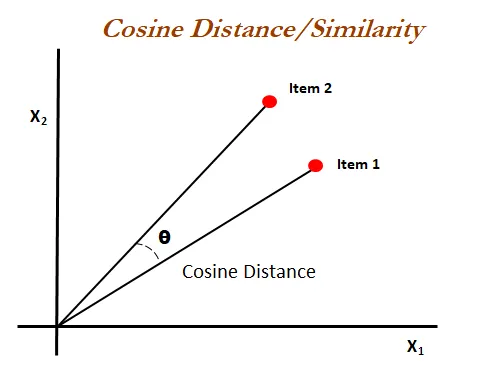

In [15]:
tokenized_reviews = df['preprocessed_text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences = tokenized_reviews, vector_size = 100, window = 5, min_count = 2, sg = 1)

df['word2vec_vector'] = df['preprocessed_text'].apply(lambda x: get_average_word2vec(x.split(), word2vec_model))
X_word2vec = np.vstack(df['word2vec_vector'].values)
df.head(2)

,title,price,categoryName,totalScore,reviewsCount,name,comentario,nota,comentario_tratado,tamanho_comentario,preprocessed_text,word2vec_vector,cluster_tfidf,cluster_word2vec
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",3,comida boa apesar de ser a peso a mesa de sala...,257,com boa apes pes mes sal falt rep com sabor em...,"[-0.017422909, 0.115831904, -0.05879532, -0.07...",6,3
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,5,gosto demais da variedade da comida não tem ch...,163,gost demal variedad com churrasc outr carn boa...,"[0.026727945, 0.07034904, -0.05540953, -0.1036...",3,1


## 4. Clusterização para a criação de categorias

### 4.1 Elbow method para determinação do número de clusters

O Elbow Method (método do cotovelo) é usado para definir o número ideal de clusters; na prática, executamos o K-means com diferentes quantidades de clusters (k), e para cada k, calculamos a inércia.

A inércia, por sua vez, é uma métrica que mede o quão "compactos" os clusters formados estão; ela representa a soma das distâncias quadradas entre cada ponto e o centroide do seu respectivo cluster. Esse valor reflete a densidade interna dos clusters: quanto menor a inércia, mais próximos estão os pontos de cada cluster ao seu centróide, indicando uma melhor coesão interna.

O "cotovelo" indica o número ideal de clusters (com mais clusters, a inertia não diminui tanto se comparado ao k do cotovelo)

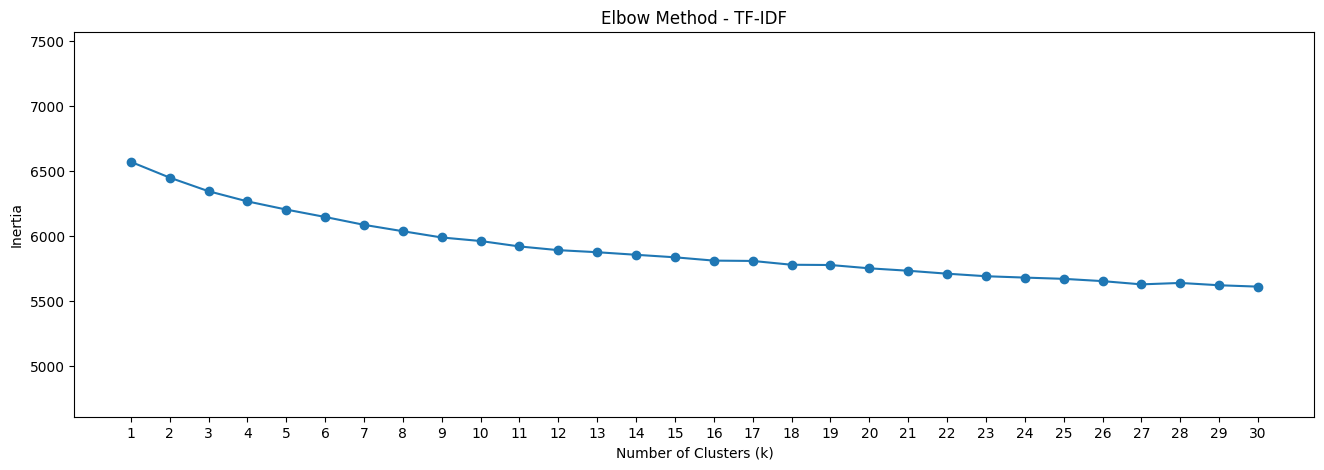

In [5]:
plot_elbow_method(X_tfidf, max_k = 30, title = "Elbow Method - TF-IDF")

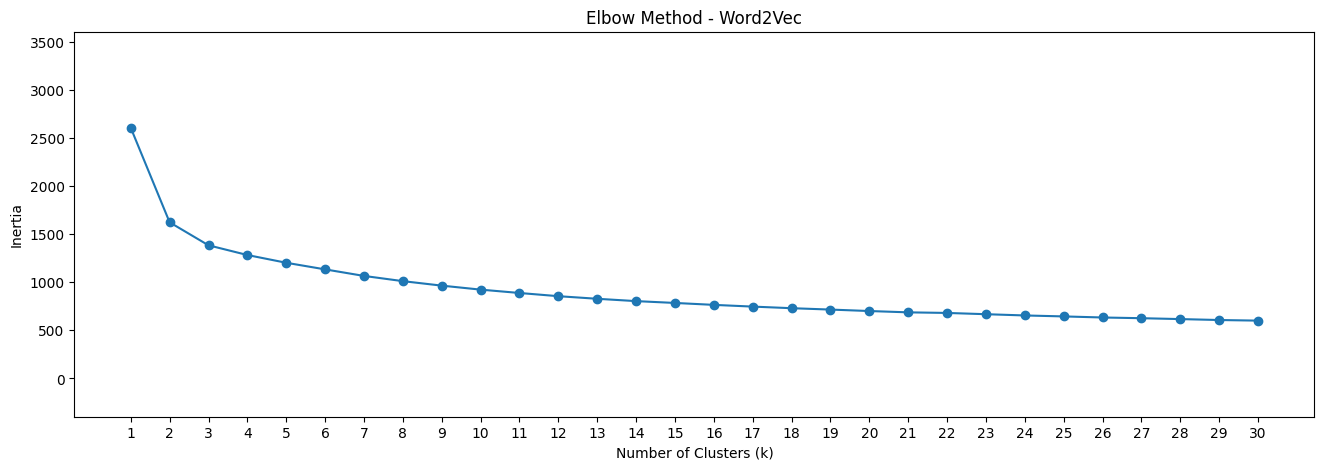

In [6]:
plot_elbow_method(X_word2vec, max_k = 30, title = "Elbow Method - Word2Vec")

### 4.3 Silhouette score

O Silhouette Score é a média do Silhouette Coefficient de todas as amostras.

O Silhouette Coefficient de uma amostra é calculado da seguinte forma:

$$ s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))} $$

Onde:
- `a(i)` é a distância média entre o ponto `i` e todos os outros pontos do mesmo cluster (cohesão)
- `b(i)` é a distância média entre o ponto `i` e todos os pontos do cluster mais próximo (separação)

Varia entre -1 (pior valor) e 1 (melhor valor).
- Valores próximos a 0 indicam que os clusters se sobrepõem
- Valores negativos indicam que uma amostra foi atribuida a um cluster errado (um cluster diferente é mais similar)

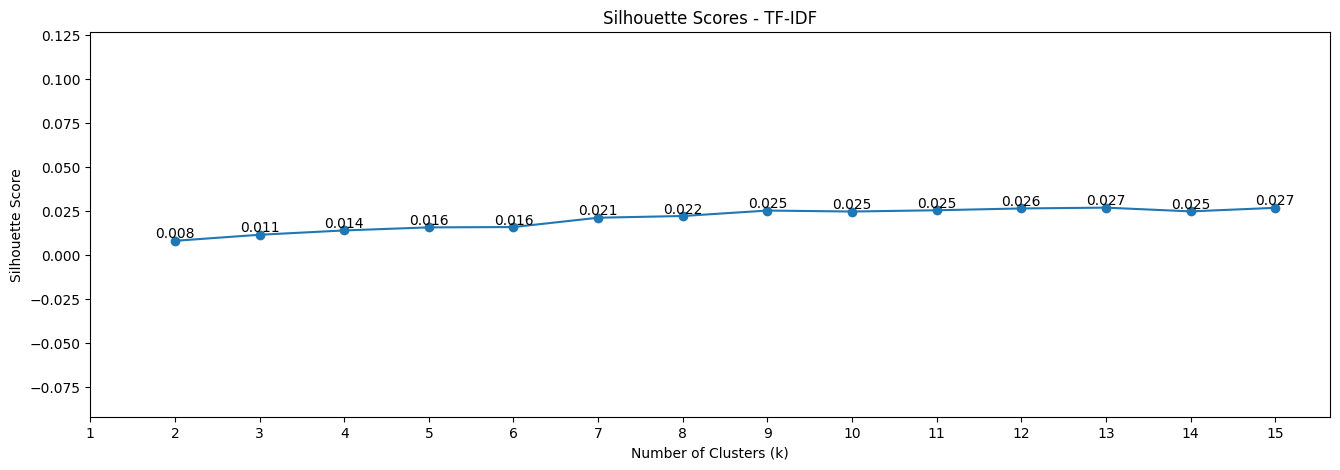

In [7]:
plot_silhouette_scores(X_tfidf, max_k = 15, title = "Silhouette Scores - TF-IDF")

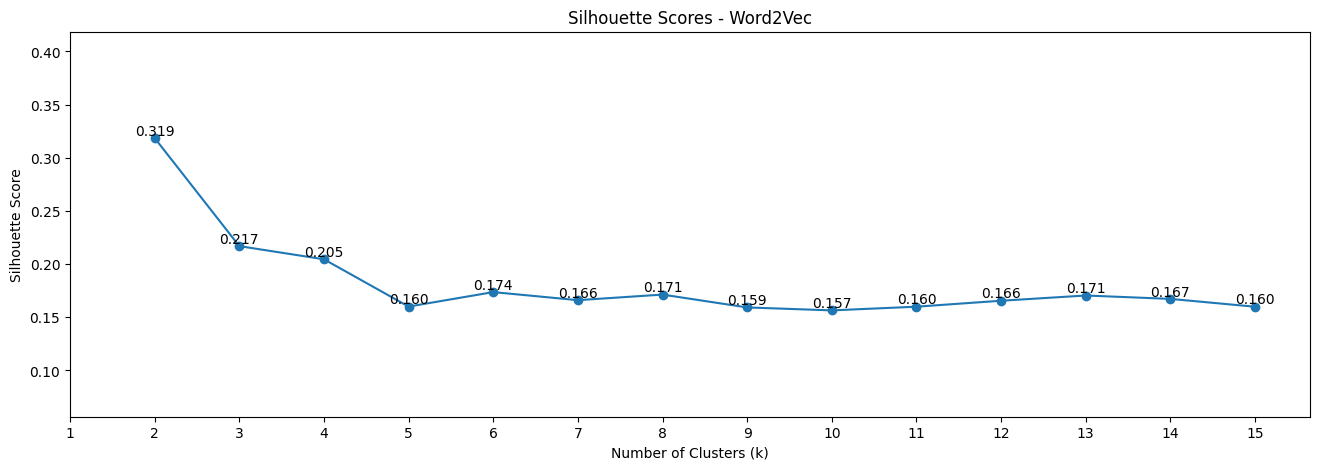

In [8]:
plot_silhouette_scores(X_word2vec, max_k = 15, title = "Silhouette Scores - Word2Vec")

### 4.2 Aplicar k-means

In [9]:
n_clusters_tfidf = 9
n_clusters_word2vec = 4

In [34]:
kmeans_tfidf = KMeans(n_clusters = n_clusters_tfidf, random_state = 42)
df['cluster_tfidf'] = kmeans_tfidf.fit_predict(X_tfidf)

kmeans_word2vec = KMeans(n_clusters = n_clusters_word2vec, random_state = 42)
df['cluster_word2vec'] = kmeans_word2vec.fit_predict(X_word2vec)

df.head(2)

,title,price,categoryName,totalScore,reviewsCount,name,comentario,nota,comentario_tratado,tamanho_comentario,preprocessed_text,word2vec_vector,cluster_tfidf,cluster_word2vec
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",3,comida boa apesar de ser a peso a mesa de sala...,257,com boa apes pes mes sal falt rep com sabor em...,"[-0.017422909, 0.115831904, -0.05879532, -0.07...",6,0
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,5,gosto demais da variedade da comida não tem ch...,163,gost demal variedad com churrasc outr carn boa...,"[0.026727945, 0.07034904, -0.05540953, -0.1036...",3,1


### 4.3 Palavras mais comuns de cada cluster, respectivas notas e gráfico do Silhouette Coefficient

In [24]:
def silhouette_plot(metodo, n_clusters = None):
    X = eval(f'X_{metodo}')

    if n_clusters == None:
        n_clusters = eval(f'n_clusters_{metodo}')

    pca = PCA(n_components=2)

    if type(eval(f'X_{metodo}')) == np.ndarray:
        X_array = eval(f'X_{metodo}')
    else:
        X_array = eval(f'X_{metodo}').toarray()

    X_reduced = pca.fit_transform(X_array)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)

    # O primeiro subplot é o gráfico de Silhouette
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    # Inicializa o KMeans com n_clusters
    kmeans_silhouette = eval(f'kmeans_{metodo}')
    cluster_labels = kmeans_silhouette.fit_predict(eval(f'X_{metodo}'))

    # Calcula o Silhouette Score médio para todos os pontos
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"Para n_clusters = {n_clusters}, o Silhouette Score médio é: {round(silhouette_avg, 5)}")

    # Calcula os scores de silhouette para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Obtém os valores de silhouette para amostras pertencentes ao cluster i, e ordena
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Rotula os gráficos de silhouette com o número do cluster
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calcula y_lower para o próximo gráfico
        y_lower = y_upper + 10  # 10 para o espaço entre clusters

    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Linha vertical para o Silhouette Score médio de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.axvline(x=0, color="black", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([# -1, -0.8, -0.6, -0.4, 
                    -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Segundo plot mostrando os clusters formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_reduced[:, 0], X_reduced[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Marcando os centróides dos clusters
    centers = pca.transform(kmeans_silhouette.cluster_centers_)
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Silhouette Score TF-IDF: 0.02517


,cluster_tfidf,top_palavras,palavras_exclusivas_top,count,nota
0,3,"[atend, com, bem, bom, lug, ambi, ped, pra, gost, garçom, local, ótim, bar, preç, agrad, excel, ...","[ped, mes, fic, val, pesso, cheg]",3719,3.940307
1,6,"[boa, com, atend, ambi, bom, lug, músic, agrad, preç, ótim, excel, bem, local, gost, beb, recom,...",[pouc],550,4.660000
2,1,"[melhor, goiân, atend, com, bar, lug, ambi, bom, preç, cervej, excel, reg, ótim, sempr, boa, bem...","[goiân, reg, cidad, pod, restaurant, disc]",512,4.707031
3,4,"[excel, atend, com, ótim, ambi, lug, bom, agrad, bem, local, preç, recom, garçom, boa, sup, deli...","[sabor, not]",468,4.914530
4,2,"[gel, cervej, atend, com, bom, boa, ótim, gost, ambi, bem, lug, excel, sup, músic, preç, sempr, ...","[petisc, tir]",459,4.692810
5,8,"[ótim, atend, com, lug, ambi, bom, agrad, local, sup, delici, preç, gost, recom, cervej, boa, pr...",[serviç],399,4.894737
6,7,"[maravilh, atend, com, lug, ambi, ótim, sup, excel, bom, agrad, recom, garçom, tud, bem, gost, d...","[ame, famíl]",354,4.949153
7,0,"[bom, atend, lug, ambi, com, agrad, preç, gost, tud, local, ótim, recom, músic, gel, delici, bem...","[salg, espaç, car, cardápi]",233,4.768240
8,5,"[top, atend, lug, com, ambi, demal, boa, gel, recom, ótim, sup, bom, agrad, garçom, gost, excel,...","[demal, show, sensac, educ]",171,4.947368


Para n_clusters = 9, o Silhouette Score médio é: 0.02517


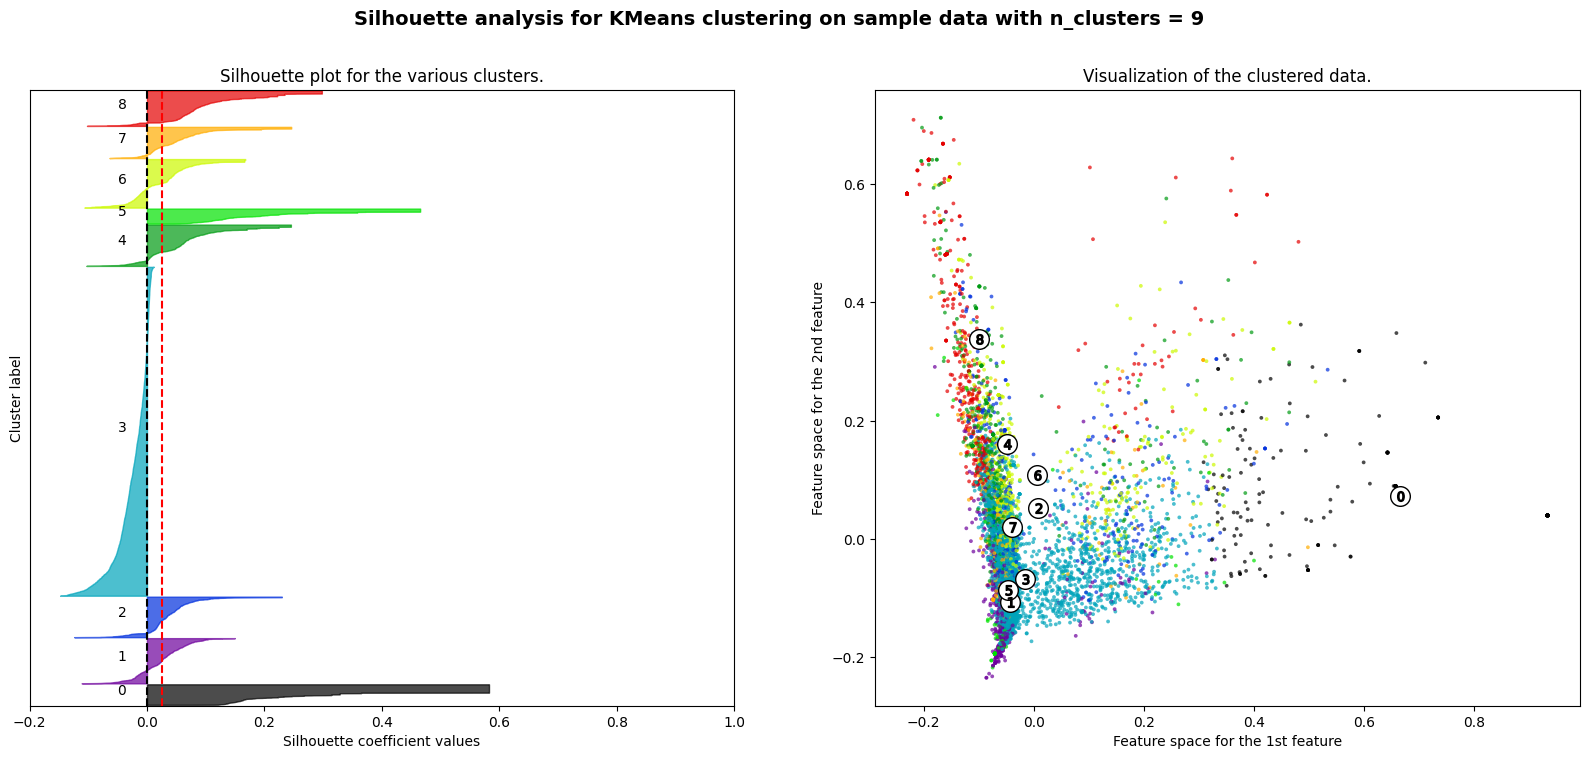

In [61]:
print(f'Silhouette Score TF-IDF: {round(silhouette_score(X_tfidf, kmeans_tfidf.labels_), 5)}')

with pd.option_context('display.max_colwidth', 100):
    display(nomes_clusters(df = df, coluna = 'cluster_tfidf')\
            .merge(df.groupby('cluster_tfidf').nota.mean().reset_index()))

silhouette_plot(metodo = 'tfidf')

Silhouette Score Word2Vec: 0.20884


,cluster_word2vec,top_palavras,palavras_exclusivas_top,count,nota
0,2,"[atend, com, ambi, ótim, bom, lug, excel, boa, agrad, gel, cervej, sup, maravilh, bem, músic, re...","[top, famili, aconcheg, perfeit, not, qual]",2272,4.861356
1,3,"[atend, com, lug, bom, ambi, bem, ótim, boa, excel, garçom, gost, local, pra, melhor, sup, sempr...","[sempr, drink, atenci]",2067,4.662796
2,0,"[atend, com, ped, pra, garçom, mes, fic, bem, bar, bom, lug, local, cheg, melhor, prat, gost, to...","[ped, mes, fic, cheg, pesso, vez, outr, péss, cas, hor, pag, client, pod]",1652,3.033293
3,1,"[melhor, com, cervej, atend, bem, preç, gel, bom, gost, goiân, excel, carn, ótim, bar, boa, serv...","[goiân, carn, serv, espet, peix, opç, porç, disc, sabor, frang]",874,4.632723


Para n_clusters = 4, o Silhouette Score médio é: 0.20884


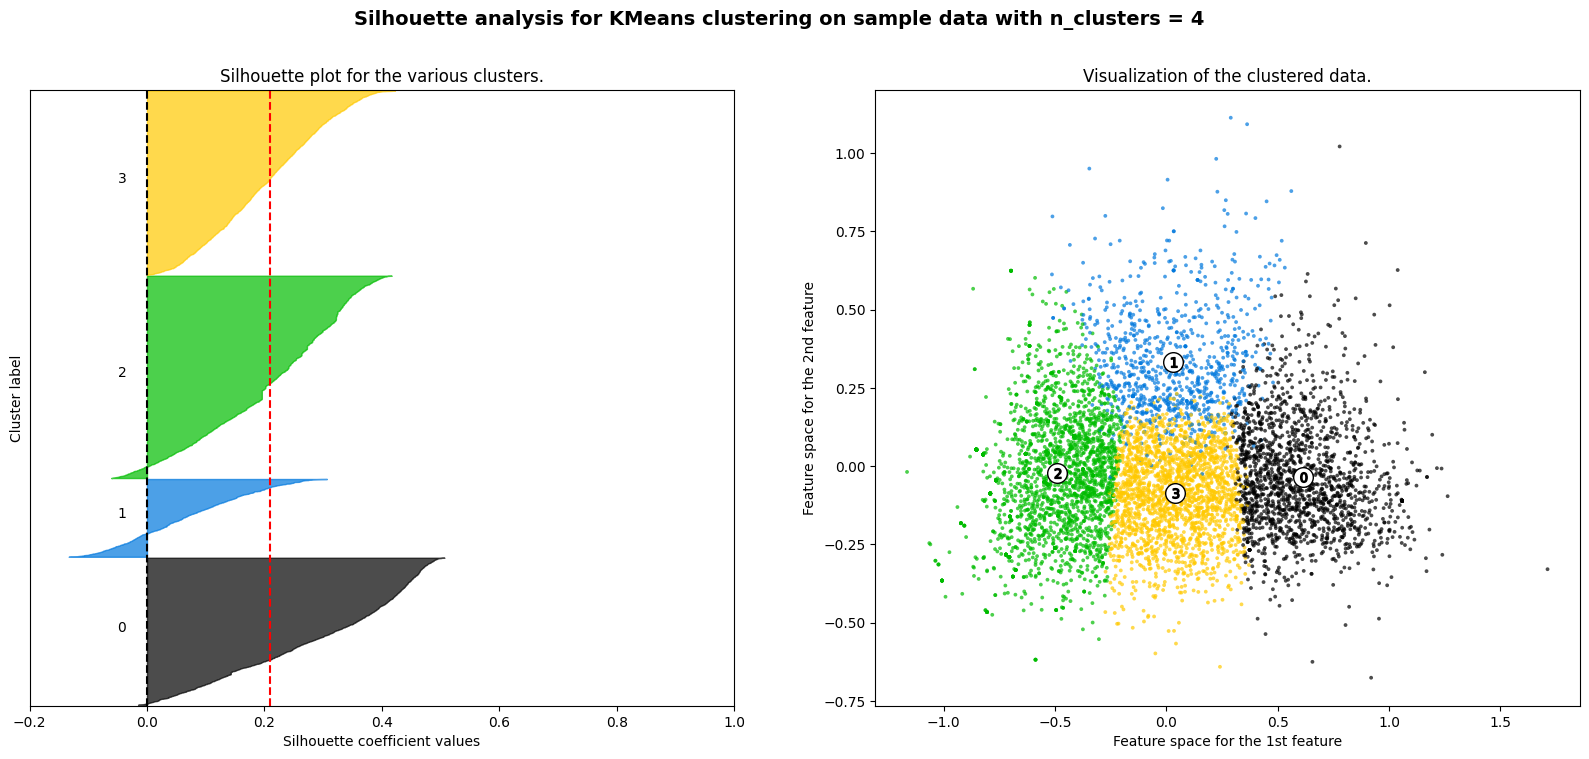

In [60]:
print(f'Silhouette Score Word2Vec: {round(silhouette_score(X_word2vec, kmeans_word2vec.labels_), 5)}')

with pd.option_context('display.max_colwidth', 100):
    display(nomes_clusters(df = df, coluna = 'cluster_word2vec')\
            .merge(df.groupby('cluster_word2vec').nota.mean().reset_index()))

silhouette_plot(metodo = 'word2vec')

### 4.4 Exemplos de comentários

In [73]:
comments_clusters_tfidf = df.copy()
comments_clusters_tfidf['amostra'] = comments_clusters_tfidf.groupby('cluster_tfidf').cumcount() + 1
comments_clusters_tfidf = comments_clusters_tfidf[comments_clusters_tfidf['amostra'] <= 5].sort_values(['cluster_tfidf', 'amostra'])\
[['cluster_tfidf', 'amostra', 'title', 'categoryName', 'totalScore', 'comentario', 'nota']]

for cluster in comments_clusters_tfidf.cluster_tfidf.unique():
    nome_cluster = nomes_clusters(df = df, coluna = 'cluster_tfidf')
    print(f"Cluster {cluster}")
    print(nome_cluster[nome_cluster['cluster_tfidf'] == cluster].reset_index()['palavras_exclusivas_top'][0])
    with pd.option_context('display.max_colwidth', 300):
        display(comments_clusters_tfidf[comments_clusters_tfidf['cluster_tfidf'] == cluster])

Cluster 0
['salg', 'espaç', 'car', 'cardápi']


,cluster_tfidf,amostra,title,categoryName,totalScore,comentario,nota
29,0,1,Bar e Restaurante Fim de Tarde,Bar e restaurante de ostras,4.7,Muito bom!,5
106,0,2,Bahrem Bar,Bar,4.4,Lugar bom com comida gostosa.,5
128,0,3,Bahrem Bar,Bar,4.4,Bom,5
240,0,4,Bar do Gauchinho,Bar,4.1,"Muito bom, um bom lugar para quem procura se divertir...",5
248,0,5,Bar do Gauchinho,Bar,4.1,Muito bom tem música ao vivo,5


Cluster 1
['goiân', 'reg', 'cidad', 'pod', 'restaurant', 'disc']


,cluster_tfidf,amostra,title,categoryName,totalScore,comentario,nota
19,1,1,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Melhor restaurante da região.,5
55,1,2,AWAR BAR,Bar e Grill,4.7,As porções são muito boas o sabor muito bom mesmo o que é o melhor dos melhores não se paga 10% amei certeza que volto mais vezes,5
81,1,3,Bahrem Bar,Bar,4.4,"Era simplesmente O MELHOR BAR de Goiânia. Mas agora em fevereiro 2022 tive A PIOR EXPERIÊNCIA de Goiânia. O bar acabou. Higiene, atendimento horrível C garçons que não conhecem e contraargumantam as publicidades do próprio Instagram. Cozinha caiu demais, e pasmem, até a marmita há consegu...",2
107,1,4,Bahrem Bar,Bar,4.4,O melhor bar de Goiânia o resto é menino babão perto dele,5
113,1,5,Bahrem Bar,Bar,4.4,"Já foi melhor, a banda tocou só 1 música e parou. Ué?!",3


Cluster 2
['petisc', 'tir']


,cluster_tfidf,amostra,title,categoryName,totalScore,comentario,nota
40,2,1,1960 Bar,Bares,4.8,"Lugar Aconchegante, comida boa, cerveja gelada, atendimento excelente.",5
54,2,2,AWAR BAR,Bar e Grill,4.7,"Adoro a comida, muito bem feita. Cerveja sempre gelada e preço bom.",5
80,2,3,Bahrem Bar,Bar,4.4,"Espaço bem decorado, agradável. Atendimento excelente dos garçons e os pratos deliciosos! Drinks diferentes e saborosos, cerveja sempre gelada!!!",5
108,2,4,Bahrem Bar,Bar,4.4,"Atendimento bom, cerveja gelada, comida boa",5
123,2,5,Bahrem Bar,Bar,4.4,Lá e uma ótima opção para beber uma gelada e comer um petisco,5


Cluster 3
['ped', 'mes', 'fic', 'val', 'pesso', 'cheg']


,cluster_tfidf,amostra,title,categoryName,totalScore,comentario,nota
1,3,1,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Gosto demais da variedade da comida. Não tem churrasco, mas tem outras carnes muito boas (frango agridoce, peixe empanado e etc). Além dos sushis e da belíssima cajuina .",5
2,3,2,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"O restaurante vende refeição por quilo, chequei as 13 horas e já estava no fim, deveriam fechar o portão, não deixar ninguém entrar...desta vez, não gostei, vou demorar a retornar.",4
3,3,3,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Ótima opção para almoço no setor Jaó. Grande variedade de comidas na opção self service, incluindo até comida japonesa. Comida muito apetitosa e com valor acessível.\nObs: não possui churrasco.\nRecomendo",5
4,3,4,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Atendimento excelente!\nComida e preço muito bom, ficou no peso 600 gramas em torno de 35$. E marmita a 20.",5
7,3,5,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"A comida é muito boa, tem muita variedade. Mas alguns pratos têm excesso de pimenta, como o bife, por exemplo.",5


Cluster 4
['sabor', 'not']


,cluster_tfidf,amostra,title,categoryName,totalScore,comentario,nota
5,4,1,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Excelente minha experiência no restaurante. Muitas opções de comida, ambiente muito confortável e um ótimo atendimento também.",5
6,4,2,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Comida muito boa e um excelente atendimento 🙏🏼👍🏼,5
10,4,3,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Comida de excelente qualidade e bem sortida.,5
22,4,4,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Muito bons ambiente, refeições e atendimento. Excelente cozinha.",4
42,4,5,1960 Bar,Bares,4.8,"Excelente atendimento, ambiente aconchegante. Pratos e petiscos deliciosos",5


Cluster 5
['demal', 'show', 'sensac', 'educ']


,cluster_tfidf,amostra,title,categoryName,totalScore,comentario,nota
246,5,1,Bar do Gauchinho,Bar,4.1,Ótimo lugar para curtir um forró top 🤩,5
247,5,2,Bar do Gauchinho,Bar,4.1,Top! Super seguro!\nPessoas simples e super educadas!\nAtendimento Top!\n\nInstagram: RayaraCastroPersonalizacao,5
272,5,3,Bar do Gauchinho,Bar,4.1,Top super recomendo 💃🕺🍺,5
282,5,4,Bar do Gauchinho,Bar,4.1,Top ótimo,5
346,5,5,Buena Brasa Bar,Bar,4.4,Chop bem gelado! Top,4


Cluster 6
['pouc']


,cluster_tfidf,amostra,title,categoryName,totalScore,comentario,nota
0,6,1,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Comida boa, apesar de ser a peso. A mesa de saladas faltava repor. A comida é saborosa, embora eu tenha achado o frango um pouco salgado. Tem comida japonesa também, já que os donos são orientais. O ambiente é muito popular e quem chega não tem muito boa aparência.",3
13,6,2,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Além da boa comida, a música ambiente é MPB de boa qualidade e faz com que o ambiente fique tranquilo e os clientes mais satisfeitos. Pelo menos no meu caso.",5
16,6,3,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Local simples porém agradável, com boa comida e bom atendimento.",4
33,6,4,Divino's Bar,Bar,4.5,Ótimo ligar boas porções,5
39,6,5,1960 Bar,Bares,4.8,"Lugar TOP! Comida boa, cervejinha Geladaça e atendimento muito humano e alegre.",5


Cluster 7
['ame', 'famíl']


,cluster_tfidf,amostra,title,categoryName,totalScore,comentario,nota
12,7,1,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Comida maravilhosa, adoro esse restaurante",5
28,7,2,Bar e Restaurante Fim de Tarde,Bar e restaurante de ostras,4.7,Que Caldo Maravilhoso...,5
43,7,3,1960 Bar,Bares,4.8,"Atendimento muito bom, jantinha maravilha.",5
136,7,4,Bahrem Bar,Bar,4.4,Local maravilhoso 🍻😋,5
159,7,5,Pitéu Bar,Bar com música ao vivo,4.5,Petiscos maravilhosos. Som muito bom.,5


Cluster 8
['serviç']


,cluster_tfidf,amostra,title,categoryName,totalScore,comentario,nota
8,8,1,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Ótima comida e preços módicos.,5
132,8,2,Bahrem Bar,Bar,4.4,Lugar ótimo e agradável!,5
256,8,3,Bar do Gauchinho,Bar,4.1,Ambiente saudável ótima música,5
267,8,4,Bar do Gauchinho,Bar,4.1,Foi ótimo,5
270,8,5,Bar do Gauchinho,Bar,4.1,Ótimo lugar recomendo,5


In [77]:
comments_clusters_word2vec = df.copy()
comments_clusters_word2vec['amostra'] = comments_clusters_word2vec.groupby('cluster_word2vec').cumcount() + 1
comments_clusters_word2vec = comments_clusters_word2vec[comments_clusters_word2vec['amostra'] <= 5].sort_values(['cluster_word2vec', 'amostra'])\
[['cluster_word2vec', 'amostra', 'title', 'categoryName', 'totalScore', 'comentario', 'nota']]

for cluster in comments_clusters_word2vec.cluster_word2vec.unique():
    nome_cluster = nomes_clusters(df = df, coluna = 'cluster_word2vec')
    print(f"Cluster {cluster}")
    print(f"Nota média: {round(df.groupby('cluster_word2vec').nota.mean()[cluster], 3)}")
    print(nome_cluster[nome_cluster['cluster_word2vec'] == cluster].reset_index()['palavras_exclusivas_top'][0])
    with pd.option_context('display.max_colwidth', 300):
        display(comments_clusters_word2vec[comments_clusters_word2vec['cluster_word2vec'] == cluster])

Cluster 0
Nota média: 3.033
['ped', 'mes', 'fic', 'cheg', 'pesso', 'vez', 'outr', 'péss', 'cas', 'hor', 'pag', 'client', 'pod']


,cluster_word2vec,amostra,title,categoryName,totalScore,comentario,nota
0,0,1,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Comida boa, apesar de ser a peso. A mesa de saladas faltava repor. A comida é saborosa, embora eu tenha achado o frango um pouco salgado. Tem comida japonesa também, já que os donos são orientais. O ambiente é muito popular e quem chega não tem muito boa aparência.",3
2,0,2,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"O restaurante vende refeição por quilo, chequei as 13 horas e já estava no fim, deveriam fechar o portão, não deixar ninguém entrar...desta vez, não gostei, vou demorar a retornar.",4
4,0,3,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Atendimento excelente!\nComida e preço muito bom, ficou no peso 600 gramas em torno de 35$. E marmita a 20.",5
7,0,4,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"A comida é muito boa, tem muita variedade. Mas alguns pratos têm excesso de pimenta, como o bife, por exemplo.",5
9,0,5,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"O lugar não tem identificação fica escondido, passei na porta e não encontrei, passando novamente é que achei.",4


Cluster 1
Nota média: 4.633
['goiân', 'carn', 'serv', 'espet', 'peix', 'opç', 'porç', 'disc', 'sabor', 'frang']


,cluster_word2vec,amostra,title,categoryName,totalScore,comentario,nota
1,1,1,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Gosto demais da variedade da comida. Não tem churrasco, mas tem outras carnes muito boas (frango agridoce, peixe empanado e etc). Além dos sushis e da belíssima cajuina .",5
3,1,2,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Ótima opção para almoço no setor Jaó. Grande variedade de comidas na opção self service, incluindo até comida japonesa. Comida muito apetitosa e com valor acessível.\nObs: não possui churrasco.\nRecomendo",5
8,1,3,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Ótima comida e preços módicos.,5
19,1,4,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Melhor restaurante da região.,5
25,1,5,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Comida por quilo de qualidade,4


Cluster 2
Nota média: 4.861
['top', 'famili', 'aconcheg', 'perfeit', 'not', 'qual']


,cluster_word2vec,amostra,title,categoryName,totalScore,comentario,nota
5,2,1,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Excelente minha experiência no restaurante. Muitas opções de comida, ambiente muito confortável e um ótimo atendimento também.",5
6,2,2,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Comida muito boa e um excelente atendimento 🙏🏼👍🏼,5
12,2,3,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Comida maravilhosa, adoro esse restaurante",5
16,2,4,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Local simples porém agradável, com boa comida e bom atendimento.",4
18,2,5,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Ambiente. Aconchegante. Comida caseira. Atendimento educado e cordial.,5


Cluster 3
Nota média: 4.663
['sempr', 'drink', 'atenci']


,cluster_word2vec,amostra,title,categoryName,totalScore,comentario,nota
10,3,1,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Comida de excelente qualidade e bem sortida.,5
13,3,2,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Além da boa comida, a música ambiente é MPB de boa qualidade e faz com que o ambiente fique tranquilo e os clientes mais satisfeitos. Pelo menos no meu caso.",5
15,3,3,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Local bom para uma refeição saudável .,5
17,3,4,Cajueiro Bar & Restaurante,Self service restaurant,4.7,"Para quem procura variar o tempero das refeições, vale a pena almoçar neste restaurante.",4
20,3,5,Cajueiro Bar & Restaurante,Self service restaurant,4.7,Bom viu,5


## 5 Classificação de uma nova avaliação

In [59]:
# new_review = "Avaliação de exemplo"
# preprocessed_review = preprocess_text(new_review)
# review_vector = get_average_word2vec(preprocessed_review, word2vec_model).reshape(1, -1)[0]

# # for i in review_vector[0]:
# #     print(type(i))

# # Prever o cluster com o KMeans treinado com Word2Vec
# predicted_cluster = kmeans_word2vec.predict(review_vector)
# predicted_cluster